## ECS659P/7026P Neural Networks and Deep Learning : Coursework Report - CIFAR-10 Classification

Arko Chatterjee

MSc Big Data Science

(Student ID : 210804539)

In [1]:
'''
importing required dependencies
'''

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
'''
checking gpu resource!
'''

num_gpus = torch.cuda.device_count()
for i in range(num_gpus):
    device_props = torch.cuda.get_device_properties(i)
    print(f"GPU {i}: {device_props.name}, {device_props.multi_processor_count} cores")

GPU 0: NVIDIA A100 80GB PCIe, 108 cores


In [3]:
'''
assigning device = cuda if gpu is available else cpu
'''

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# define batch size for train + test dataloader
batch_size = 32


# initialize dataloader 

transform_train = transforms.Compose([
    transforms.Resize(32), # resize image to 32x32
    transforms.RandomCrop(32, padding=2), #  randomly crop input image -> 32x32 with padding = 2
    #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(), # data augmentation by horizontal flip of data
    transforms.ToTensor(), # convert to pytorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalize tensor value
])

transform_test = transforms.Compose([
    transforms.Resize(32),# resize image to 32x32
    transforms.ToTensor(), # convert to pytorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalize tensor value
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_train)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

# define labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Training Data :  1
Class Label :  deer


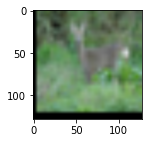

--------------------------------
Training Data :  2
Class Label :  ship


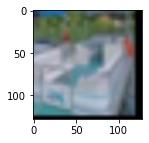

--------------------------------
Training Data :  3
Class Label :  plane


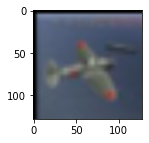

--------------------------------
Training Data :  4
Class Label :  ship


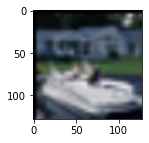

--------------------------------
Training Data :  5
Class Label :  truck


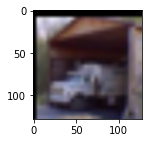

--------------------------------


In [5]:
# visualize dataset

def imshow(img):
    transform = transforms.Compose([transforms.Resize((128, 128))])
    img = transform(img)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

count = 5
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:count], labels[:count] # first n training images from count variable

for single in range(0,count):
    print('Training Data : ' , (single+1))
    label_class = classes[labels[single]]
    print('Class Label : ', label_class)
    imshow(images[single])
    print('--------------------------------')

In [6]:
'''
understanding our dataset
'''

print('total train dataset :', len(trainset))
print('total test dataset :', len(testset))
print('batch size :' , batch_size)
print('train loader size :', len(trainloader))
print('test loader size :', len(testloader))

total train dataset : 50000
total test dataset : 10000
batch size : 32
train loader size : 1563
test loader size : 313


In [7]:
'''
defining class Block - architected as defined in the coursework!

each block should provide the output for K iterations : 

->  out = a_1 * conv_1(x) + ..... + a_K * conv_K(x)
->  a = non-linear activation * spatial avg pool (x)
->  x = input image tensor
'''

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, K): 
        super(Block, self).__init__()
        self.in_channels = in_channels # defining input no of channels 
        self.out_channels = out_channels # defining output no of channels 
        self.K = K # defining the number of iterations of a * conv(x)

        # linear mlp layer
        self.fc = nn.Linear(in_channels, K)

        # spatial average pooling layer of input tensor using AdaptiveAvgPool2d
        self.spatial_pool = nn.AdaptiveAvgPool2d(1) 

        # choosing sigmoid as non-linear activation function
        self.activation = nn.Sigmoid()

        # defining the final summation output of 'a' and 'convolution layer' 
        self.convs = nn.ModuleList()
        for i in range(K):
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False))

    def forward(self, x):
        # computing vector 'a' -> non-linear activation * spatial avg pool (x)
        a = self.spatial_pool(x).view(x.size(0), self.in_channels)
        a = self.fc(a)
        a = self.activation(a)

        # computing the final output -> sum of 'a' * 'conv layer' till K
        out = 0
        for i in range(self.K):
            out += a[:, i].view(x.size(0), 1, 1, 1) * self.convs[i](x) # clarification

        return out

In [8]:
'''
understanding architecture of block class with input of 3 channels!
'''
block_model = Block(3, 64, K=4)
block_model

Block(
  (fc): Linear(in_features=3, out_features=4, bias=True)
  (spatial_pool): AdaptiveAvgPool2d(output_size=1)
  (activation): Sigmoid()
  (convs): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [54]:
'''
defining the final Backbone Model architecture

implementing the following model layers : 
-> 5 layers of Block class with variations in/out channe
-> sigmoid function as an activation layer
-> average pooling with kernal size = 2x2 and stride = 1 as a pooling layer

classifer layer :
-> adaptive average pooling used on the output from the last block layer
-> thereafter it is flattened and a simple mlp layer is used to translate the out channels to 10 label classes
'''

class BackboneModel(nn.Module):
    def __init__(self, num_classes=10):
        super(BackboneModel, self).__init__()
        
        self.num_classes = num_classes
        
        #defining the activation and pooling functions
        self.Sigmoid = nn.Sigmoid()
        self.Avg = nn.AvgPool2d(2, padding=1,stride=1)
        
        # defining blocks used to create the model with it's corresponding batch normalisation
        self.block0 = Block(3, 64, K=3)
        self.bn0 = nn.BatchNorm2d(64)
        
        self.block1 = Block(64, 64, K=3)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.block2 = Block(64, 128, K=3)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.block3 = Block(128, 128, K=3)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.block4 = Block(128, 256, K=3)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.block5 = Block(256, 256, K=3)
        self.bn5 = nn.BatchNorm2d(256)
        
#         self.block6 = Block(256, 512, K=3)
#         self.bn6 = nn.BatchNorm2d(512)
        
#         self.block7 = Block(512, 512, K=3)
#         self.bn7 = nn.BatchNorm2d(512)
        
        # defining the final classifier layer -> according to the requirement of the coursework
        self.spatial_pool = nn.AdaptiveAvgPool2d(1)
        self.Fltn = nn.Flatten()
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
          
        # final backbone model -> shown below is the best model providing the best accuracy yet!
        
        x = self.block0(x)
        x = self.Sigmoid(x)
        x = self.Avg(x)
        x = self.bn0(x)
        
        x = self.block1(x)
        x = self.Sigmoid(x)
        x = self.Avg(x)
        x = self.bn1(x)
        
        x = self.block2(x)
        x = self.Sigmoid(x)
        x = self.Avg(x)
        x = self.bn2(x)
        
        x = self.block3(x)
        x = self.Sigmoid(x)
        x = self.Avg(x)
        x = self.bn3(x)
      
        x = self.block4(x)
        x = self.Sigmoid(x)
        x = self.Avg(x)
        x = self.bn4(x)
        
        x = self.block5(x)
        x = self.Sigmoid(x)
        x = self.Avg(x)
        x = self.bn5(x) 
        
        # final classification layer
        
        x = self.spatial_pool(x)
        x = self.Fltn(x)
        x = self.classifier(x)

        return x

In [55]:
'''
initialzing model to use device = gpu or cpu for training!
'''

backbone = BackboneModel().to(device)

In [56]:
'''
defining loss and optimizer functions and it's corresponding hyperparameters 

'''

num_epochs = 80                 # running for 80 epochs

loss_fn = nn.CrossEntropyLoss() # choosing cross entropy loss as loss function

optimizer = optim.Adam(         # choosing adam optimzer 
    backbone.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),         # decay rates for moving averages of gradient and its square
    eps=1e-08,                  # term added to the denominator to improve numerical stability
    weight_decay=0.0001)        # L2 regularization parameter

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.01)

In [57]:
start_time = time.time()

# list to store corresponding train accuracy, train loss, test accuray per epoch
train_losses = [] 
train_accs = []

test_accs = []

print('started training -->')


for epoch in range(num_epochs):
    
    '''
    training iteration
    '''
    run_loss_train = 0.0
    run_acc_train = 0.0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        
        # forward pass
        outputs = backbone(images)
        loss = loss_fn(outputs, labels)

        # fackward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update running loss and accuracy
        run_loss_train += loss.item()
        preds_train = outputs.argmax(dim=1)
        run_acc_train += torch.sum(preds_train == labels).item() / labels.size(0)



    # compute & save epoch loss and accuracy for each epoch
    epoch_loss = run_loss_train / len(trainloader)
    epoch_acc = run_acc_train / len(trainloader)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    
    '''
    validation iteration
    '''
    with torch.no_grad(): # no gradient calculation while computing test/validation accuracy
        running_acc_val = 0.0
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs_val = backbone(images)

            # compute validation accuracy
            preds_val = outputs_val.argmax(dim=1)
            running_acc_val += torch.sum(preds_val == labels).item() / labels.size(0)

    # compute & save val accuracy for each epoch
    test_epoch_acc = running_acc_val / len(testloader)
    test_accs.append(test_epoch_acc)
    
    # print status per epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy : {:.4f}, Test Accuracy : {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc, test_epoch_acc))
    
    # Update the learning rate scheduler at every epoch
    scheduler.step()
    
    #torch.cuda.empty_cache() # using to free up GPU space!
    

end_time = time.time()

print("training completed in : {:.2f} seconds".format(end_time - start_time))


# save model locally
# torch.save(backbone.state_dict(), 'model-3-003.pt')

started training -->
Epoch [1/80], Train Loss: 1.7606, Train Accuracy : 0.3374, Test Accuracy : 0.4369
Epoch [2/80], Train Loss: 1.4075, Train Accuracy : 0.4838, Test Accuracy : 0.5274
Epoch [3/80], Train Loss: 1.2329, Train Accuracy : 0.5569, Test Accuracy : 0.5619


KeyboardInterrupt: 

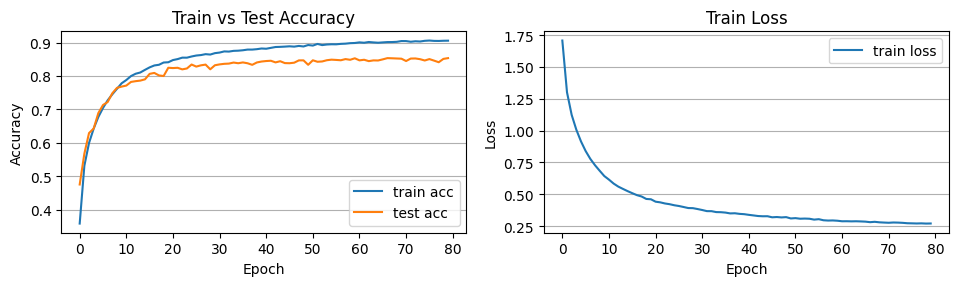

In [14]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
fig.tight_layout(pad=2.5)

'''
plot train vs test/validation accuracy
'''

ax1.plot(train_accs, label='train acc')
ax1.plot(test_accs, label='test acc')
ax1.grid(axis='y')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train vs Test Accuracy')
ax1.legend()

'''
plot train loss
'''
ax2.plot(train_losses, label='train loss')
ax2.grid(axis='y')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Train Loss')
ax2.legend()


plt.show()

Actual: ship | Predicted  : ship
Correct Prediction


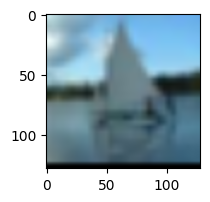

-----------------------------------------
Actual: deer | Predicted  : deer
Correct Prediction


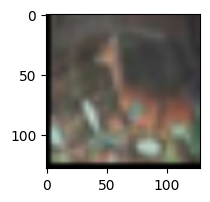

-----------------------------------------
Actual: dog | Predicted  : dog
Correct Prediction


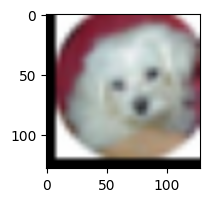

-----------------------------------------
Actual: cat | Predicted  : cat
Correct Prediction


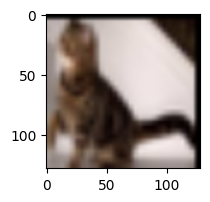

-----------------------------------------
Actual: plane | Predicted  : plane
Correct Prediction


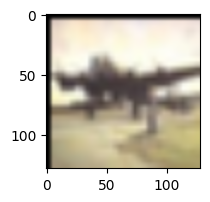

-----------------------------------------
Actual: horse | Predicted  : horse
Correct Prediction


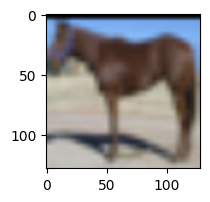

-----------------------------------------
Actual: car | Predicted  : car
Correct Prediction


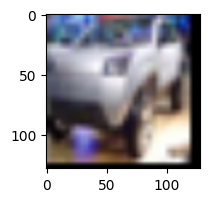

-----------------------------------------
Actual: bird | Predicted  : bird
Correct Prediction


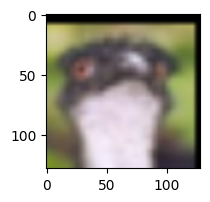

-----------------------------------------
Actual: dog | Predicted  : dog
Correct Prediction


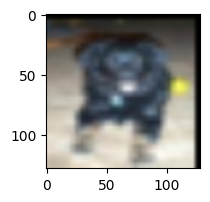

-----------------------------------------
Actual: dog | Predicted  : dog
Correct Prediction


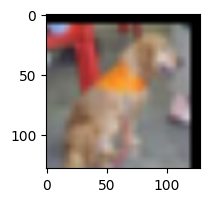

-----------------------------------------
Actual: plane | Predicted  : plane
Correct Prediction


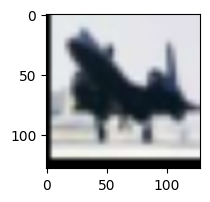

-----------------------------------------


In [15]:
'''
showing predicted response for 10 items from test/validation dataset
'''

def imshow2(img):
    transform = transforms.Compose([transforms.Resize((128, 128))])
    img = transform(img)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()[0]
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# model on evaluation mode
backbone.eval()


count = 0

with torch.no_grad(): # no gradient calculation while computing over test/validation data
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = backbone(images)

        # compute predicted labels
        predicted = outputs.argmax(dim=1)

        # visualise first 10 predictions from the test/validation dataset
        pred_label_class = classes[predicted.tolist()[0]]
        actual_label_class = classes[labels.tolist()[0]]
        status = 'Correct Prediction' if predicted.tolist()[0] == labels.tolist()[0] else 'Incorrect Prediction'
        print('Actual: {} | Predicted  : {}'.format(actual_label_class, pred_label_class))
        print(status)
        imshow2(images)
        print('-----------------------------------------')
        
        if count == 10:
            break
        
        count +=1